# dataset

In [4]:
# Standard library imports
from datetime import datetime, timedelta

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

/Users/I748920/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
from scripts.get_top_stocks import *
top_stocks_long, top_stocks_long_short = generate_top_stocks_df()
common_top_stocks = get_common_top_stocks(top_stocks_long, top_stocks_long_short)

# specify variables for dataset generation
start_date = '2023-01-01'
end_date = '2024-08-01'
interval = "1h"
trading_days_per_year = 252
hours_per_day = 6.5


Results saved to 'top_30_stocks_long_only.csv' and 'top_30_stocks_long_short.csv'

Detailed metrics for top stock (Long-Only Strategy) SMCI:
Final Close Price: 284.26
60-day Return: 250.61%
Average Hourly Volatility: 0.6678
Average Sharpe Ratio: 1.6242
Average Hourly Volume: 355714

num common_top_stocks:  35


In [6]:
from scripts.generate_dataset_features import *


df = get_all_stock_features_df(
    stocks_list=common_top_stocks,
    start_date=start_date,
    end_date=end_date,
    interval=interval,
    trading_days_per_year=trading_days_per_year, 
    hours_per_day=hours_per_day)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [7]:
# functions to add target column to df

def categorize_by_percentile(values,percentile_list,labels):
    # Compute percentiles
    percentiles = np.percentile(values, percentile_list)
    # Use pd.cut to bin the values
    categories = pd.cut(values, bins=[-np.inf] + percentiles.tolist() + [np.inf], labels=labels, include_lowest=True)
    
    return categories

def add_target_cols(df,percentile_list,labels):
    new_df = pd.DataFrame()
    
    for stock_name in df.stock_name.unique():
        stock_df = df[df['stock_name']==stock_name]
        stock_df["Stock_Position"] = categorize_by_percentile(stock_df["Log_Return_shift"].to_numpy(),percentile_list,labels)        
        label_mapping = {labels[i]:i for i in range(len(labels))}
        stock_df["Target"] = stock_df["Stock_Position"].apply(lambda x:label_mapping[x])
        new_df = pd.concat([new_df,stock_df],ignore_index=True)
    
    return new_df

In [17]:
# create target column

percentile_list = [20,40,60,80]
labels = ['strong sell', 'sell', 'hold', 'buy', 'strong buy']
# labels = ['sell', 'hold', 'buy']

df = add_target_cols(df,percentile_list,labels)

/var/folders/ff/wvby4kh52j96myw15h33jjk40000gn/T/ipykernel_56778/3840593447.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df["Stock_Position"] = categorize_by_percentile(stock_df["Log_Return_shift"].to_numpy(),percentile_list,labels)
/var/folders/ff/wvby4kh52j96myw15h33jjk40000gn/T/ipykernel_56778/3840593447.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df["Target"] = stock_df["Stock_Position"].apply(lambda x:label_mapping[x])
/var/folders/ff/wvby4kh52j96myw15h33jjk40000gn/T/ipyker

In [19]:
df

,Datetime,Open,High,Low,Close,Adj Close,Volume,Log_Return,EMAVolumeDiff2,SMAVolumeDiff2,...,MACD16,MACD32,MACD64,MACD128,MACD256,FamaFrenchMktReturns,Log_Return_shift,stock_name,Stock_Position,Target
0,2023-02-24 13:30:00-05:00,57.620003,57.734001,57.487999,57.646996,57.646996,103631,0.000191,-0.076142,-0.074331,...,4.632076,3.735067,2.118455,0.268653,-0.343023,-1.09,0.001266,AVGO,hold,2
1,2023-02-24 14:30:00-05:00,57.644001,58.023998,57.581001,57.720001,57.720001,152926,0.001266,0.097492,0.192141,...,-4.903428,15.602799,3.436810,0.349074,-0.365910,-1.09,0.001593,AVGO,buy,3
2,2023-02-24 15:30:00-05:00,57.760998,57.857002,57.582500,57.812000,57.812000,293678,0.001593,0.212381,0.315161,...,-1.480785,-6.742368,9.950571,0.478475,-0.401372,-1.09,0.017388,AVGO,strong buy,4
3,2023-02-27 09:30:00-05:00,58.586998,58.980000,58.433002,58.826000,58.826000,279407,0.017388,0.046407,-0.024902,...,0.029925,-0.344404,-0.579568,-0.346726,5.261195,0.31,-0.004848,AVGO,strong sell,0
4,2023-02-27 10:30:00-05:00,58.808002,58.840004,58.500000,58.541496,58.541496,218036,-0.004848,-0.069663,-0.123373,...,0.340360,-0.553998,-0.937091,-0.739570,-1.806773,0.31,0.001442,AVGO,hold,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89934,2024-07-30 13:30:00-04:00,103.071098,104.070000,102.940002,103.919998,103.919998,2017796,0.007826,-0.128269,-0.196618,...,4.539734,1.431240,1.318580,1.077183,0.431512,0.68,-0.005984,MU,strong sell,0
89935,2024-07-30 14:30:00-04:00,103.919998,104.410004,103.260002,103.300003,103.300003,1907208,-0.005984,-0.066485,-0.028175,...,2.530786,1.300820,1.227392,1.019769,0.421125,0.68,-0.007384,MU,strong sell,0
89936,2024-07-30 15:30:00-04:00,103.269997,103.349998,102.379997,102.540001,102.540001,2991108,-0.007384,0.118136,0.221280,...,1.852822,1.158428,1.116428,0.948070,0.405730,0.68,0.068999,MU,strong buy,4
89937,2024-07-31 09:30:00-04:00,109.800003,110.812401,108.160004,109.864998,109.864998,7445316,0.068999,0.271565,0.426794,...,-0.201396,-0.433364,-1.071457,-3.287237,1.876995,0.68,0.003045,MU,buy,3


In [21]:
df.Target.value_counts()

Target
0    17995
4    17995
1    17994
3    17994
2    17961
Name: count, dtype: int64

In [26]:
# additional logic to ensure buy remains +ve and sell remainvs -ve

print(len(df[(df.Log_Return_shift < 0) & (df.Stock_Position == 'buy')]))
print(len(df[(df.Log_Return_shift < 0) & (df.Stock_Position == 'strong buy')]))

print(len(df[(df.Log_Return_shift > 0) & (df.Stock_Position == 'sell')]))
print(len(df[(df.Log_Return_shift > 0) & (df.Stock_Position == 'strong sell')]))

# all good

0
0
0
0


In [28]:
# sort df according to date
df1 = df.sort_values("Datetime").reset_index(drop=True)

# train test split on index
train_size, val_size, test_size = 0.8, 0.1, 0.1
train_size, val_size, test_size = int(len(df1) * train_size), int(len(df1) * val_size), int(len(df1) * test_size)
train_df = df1.iloc[:train_size]
val_df = df1.iloc[train_size:train_size + val_size]
test_df = df1.iloc[train_size + val_size:]

train_df.shape,val_df.shape,test_df.shape

((71951, 84), (8993, 84), (8995, 84))

In [30]:
test_df.Target.value_counts()

Target
0    1932
3    1843
1    1750
2    1748
4    1722
Name: count, dtype: int64

In [32]:
df.columns, df.columns[8:-4]

(Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
        'Log_Return', 'EMAVolumeDiff2', 'SMAVolumeDiff2', 'EMACloseDiff2',
        'SMACloseDiff2', 'VWAP2', 'VolatilityStdDev2', 'Volatility2',
        'Momentum2', 'EMAVolumeDiff4', 'SMAVolumeDiff4', 'EMACloseDiff4',
        'SMACloseDiff4', 'VWAP4', 'VolatilityStdDev4', 'Volatility4',
        'Momentum4', 'EMAVolumeDiff8', 'SMAVolumeDiff8', 'EMACloseDiff8',
        'SMACloseDiff8', 'VWAP8', 'VolatilityStdDev8', 'Volatility8',
        'Momentum8', 'EMAVolumeDiff16', 'SMAVolumeDiff16', 'EMACloseDiff16',
        'SMACloseDiff16', 'VWAP16', 'VolatilityStdDev16', 'Volatility16',
        'Momentum16', 'EMAVolumeDiff32', 'SMAVolumeDiff32', 'EMACloseDiff32',
        'SMACloseDiff32', 'VWAP32', 'VolatilityStdDev32', 'Volatility32',
        'Momentum32', 'EMAVolumeDiff64', 'SMAVolumeDiff64', 'EMACloseDiff64',
        'SMACloseDiff64', 'VWAP64', 'VolatilityStdDev64', 'Volatility64',
        'Momentum64', 'EMAVolumeDiff1

In [34]:
features = df.columns[8:-4]
print(len(features))
target = "Target"

X_train = train_df[features].to_numpy()
y_train = train_df[target].to_numpy()
print(X_train.shape,y_train.shape)

X_val = val_df[features].to_numpy()
y_val = val_df[target].to_numpy()
print(X_val.shape,y_val.shape)

X_test = test_df[features].to_numpy()
y_test = test_df[target].to_numpy()
print(X_test.shape,y_test.shape)

72
(71951, 72) (71951,)
(8993, 72) (8993,)
(8995, 72) (8995,)


In [36]:
# check number of classes in target is correct

set(y_train),set(y_val),set(y_test)

({0, 1, 2, 3, 4}, {0, 1, 2, 3, 4}, {0, 1, 2, 3, 4})

In [38]:
# using PCA

from scripts.train_predict import *

# standardise the values and selectKbest
scaler = StandardScaler()
pca = PCA(n_components = 0.95)

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)
X_train = pca.fit_transform(X_train)

# Transform the validation data
X_val = scaler.transform(X_val)
X_val = pca.transform(X_val)

# Transform the test data
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((71951, 26), (71951,), (8993, 26), (8993,), (8995, 26), (8995,))

In [42]:
# sample check

X_train[100],y_train[100]

(array([-1.31978368, -0.05236149, -2.67307776, -0.16396976,  0.52011398,
        -0.61720978, -0.11301503,  1.22153526,  1.00231949, -2.12395102,
         0.26820878, -0.20258455, -0.0183045 ,  0.04114264,  0.10889661,
         1.17166561, -2.19195209, -0.22134455,  0.07876193,  0.03593327,
        -1.2561156 ,  0.72792956,  0.82489874, -0.89813411,  0.08740607,
         1.54183588]),
 2)

In [66]:
# check distribution of target

print(train_df.Target.value_counts())
print(val_df.Target.value_counts())
print(test_df.Target.value_counts())

Target
4    14567
1    14406
3    14373
0    14356
2    14249
Name: count, dtype: int64
Target
2    1964
1    1838
3    1778
0    1707
4    1706
Name: count, dtype: int64
Target
0    1932
3    1843
1    1750
2    1748
4    1722
Name: count, dtype: int64


# model

In [47]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
# from tqdm import tqdm
from alive_progress import alive_it

def train():
    # initialise training params
    best_score = float('inf')
    best_params = None
    best_model = None
    

    param_grid = {
        'hidden_layer_sizes': [(8)], # Different architectures
        'activation': ['relu'], # Different activation functions
        'solver': ['adam'], # Different solvers
        'alpha': [0.005], # Different regularization terms
        'learning_rate': ['adaptive'], # Different learning rates
    }

    for params in alive_it(ParameterGrid(param_grid)):
        model = MLPClassifier(max_iter=1000, **params) # initialise new model before each run
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        
        if best_score > score:
            best_score = score
            best_params = params
            best_model = model
            print(f"score: {round(best_score,7)}")

    print(f"Best parameters found: {best_params}")
    print(f"Best validation score: {round(best_score,5)}")

    return best_model, best_params, best_score, X_test, y_test

def predict(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy score: {round(score,5)}")
    
    return y_pred

def train_predict():
    best_model, best_params, best_score, X_test, y_test = train()
    y_pred = predict(best_model, X_test, y_test)
    acc = accuracy_score(y_test, y_pred)
    
    return best_model, best_params, best_score, acc, y_pred
    

In [49]:
best_model, best_params, best_score, acc, y_pred = train_predict()

on 0: score: 0.2638719
|████████████████████████████████████████| 1/1 [100%] in 2.9s (0.35/s) 
Best parameters found: {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': 8, 'learning_rate': 'adaptive', 'solver': 'adam'}
Best validation score: 0.26387
Test set accuracy score: 0.23513


In [56]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 214, 1: 173, 2: 2145, 3: 2614, 4: 3849}

accuracy: 20.47


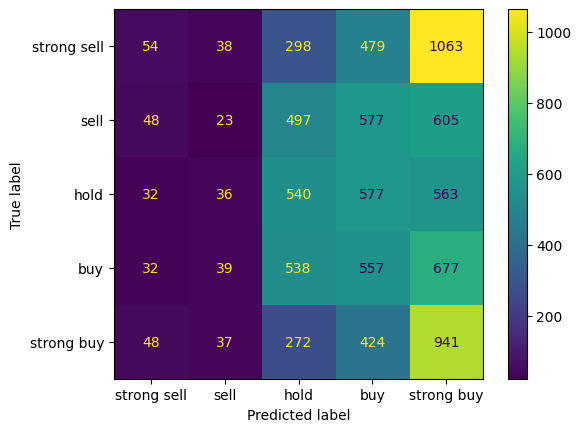

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(f"accuracy: {round(acc*100,2)}")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

In [64]:
## predict on indiv stocks
## pca transformed features only

for stock_name in test_df.stock_name.unique():
    stock_df = test_df[test_df['stock_name']==stock_name]
    stock_X_test = stock_df[features].to_numpy()
    stock_y_test = stock_df[target].to_numpy()
    # print(stock_X_test.shape,stock_y_test.shape)

    stock_X_test = pca.transform(stock_X_test)
    # print(stock_X_test.shape,stock_y_test.shape)

    stock_preds = best_model.predict(stock_X_test)
    acc = accuracy_score(stock_y_test, stock_preds)

    print(f"{stock_name}: {round(acc*100,2)}")

III.L: 23.32
META: 22.49
WDAY: 21.29
DDOG: 18.88
ABNB: 18.07
AMZN: 23.29
AMD: 22.49
TTD: 22.89
CRWD: 25.7
NVDA: 20.08
MU: 22.89
INTU: 22.49
AVGO: 24.9
TSLA: 19.28
MRNA: 27.31
TEAM: 24.5
MSFT: 20.08
ZS: 22.89
ADBE: 22.89
LRCX: 18.47
SNPS: 23.69
DASH: 21.29
SMCI: 28.92
PANW: 24.1
MDB: 24.5
AMAT: 24.1
INTC: 19.68
CDNS: 19.68
MRVL: 22.89
BKNG: 19.68
PDD: 22.89
MELI: 21.69
CPRT: 20.88
RR.L: 20.76
MKS.L: 20.47
